In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache import BehaviorProjectCache as bpc
from visual_behavior.translator.allensdk_sessions import sdk_utils
import visual_behavior.utilities as vbu
import visual_behavior.database as db
import scipy.misc
import os

from tqdm import tqdm

import matplotlib.pyplot as plt

/home/dougo/.local/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
%matplotlib notebook
%widescreen

In [3]:
def get_movie_filepath(osid):
    well_known_files = db.get_well_known_files(osid).set_index('name')
    behavior_video_path = ''.join(well_known_files.loc['RawBehaviorTrackingVideo'][['storage_directory', 'filename']].tolist())
    return behavior_video_path

In [4]:
def get_sync_data(osid):
    well_known_files = db.get_well_known_files(osid).set_index('name')
    sync_path = ''.join(well_known_files.loc['OphysRigSync'][['storage_directory', 'filename']].tolist())
    sync_data = vbu.get_sync_data(sync_path)
    return sync_data

In [5]:
manifest_path = "/home/dougo/manifest.json"
cache = bpc.from_lims(manifest=manifest_path)

In [6]:
osid = 841671312
oeid = 841948542

In [7]:
session = cache.get_session_data(oeid)

In [8]:
sync_data = get_sync_data(osid)
len(sync_data['cam1_exposure_rising'])

/home/dougo/.conda/envs/visual_behavior/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


135917

In [45]:
movie_path = get_movie_filepath(osid)
movie = vbu.Movie(movie_path,sync_timestamps=sync_data['cam1_exposure_rising'])

In [48]:
licks = session.licks

In [49]:
licks[:20]

,time
0,1.01708
1,3.14674
2,3.27260
3,5.77010
4,5.95047
5,8.97777
6,9.77713
7,10.59226
8,10.79162
9,11.10806


In [76]:
np.argmin(np.abs(sync_data['cam1_exposure_rising']-9.77713))

286

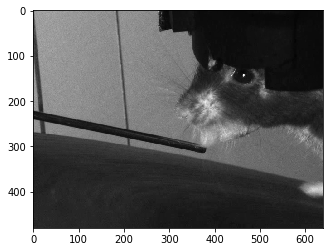

In [75]:
fig,ax=plt.subplots()
ax.imshow(movie.get_frame(time=9.77713))

In [55]:
predictions_path = '/ssd1/lick_detection_model/three_class_model/predictions_841948542.npz'
predictions = np.load(predictions_path)

In [59]:
list(predictions.keys())

['all_preds']

In [116]:
predictions['all_preds'].shape

(4096, 3)

In [118]:
np.diff(sync_data['cam1_exposure_rising'])

array([0.01103, 0.01715, 0.03331, ..., 0.03324, 0.0335 , 0.04362])

In [115]:
predictions['all_preds'][0]

array([9.8497850e-01, 3.9105635e-05, 1.4982326e-02], dtype=float32)

<IPython.core.display.Javascript object>


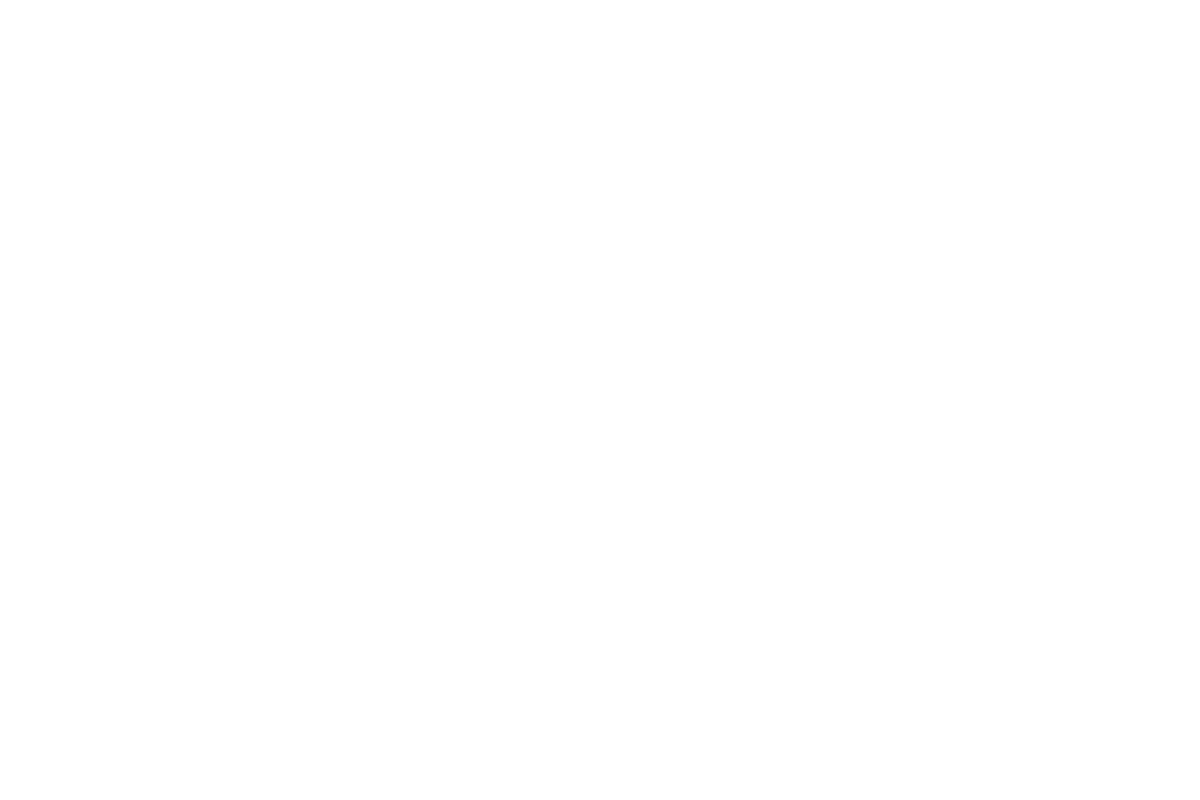

BadZipFile: Bad CRC-32 for file 'all_preds.npy'

In [121]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
frame = 23

ax[0].cla()
ax[1].cla()

current_time = sync_data['cam1_exposure_rising'][frame]
ax[0].imshow(movie.get_frame(frame))
ax[0].set_title('lick_prob = {:0.4f}'.format(predictions['all_preds'][frame][2]))
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].plot(sync_data['cam1_exposure_rising'][:4096],predictions['all_preds'][:,2])
ax[1].plot(licks.query('time <= @max_time'), np.ones_like(licks.query('time <= @max_time')), 'ok')
ax[1].set_xlim(current_time-1,current_time+1)
ax[1].axvline(current_time,color='black',linewidth=2)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('lick probability')

<IPython.core.display.Javascript object>


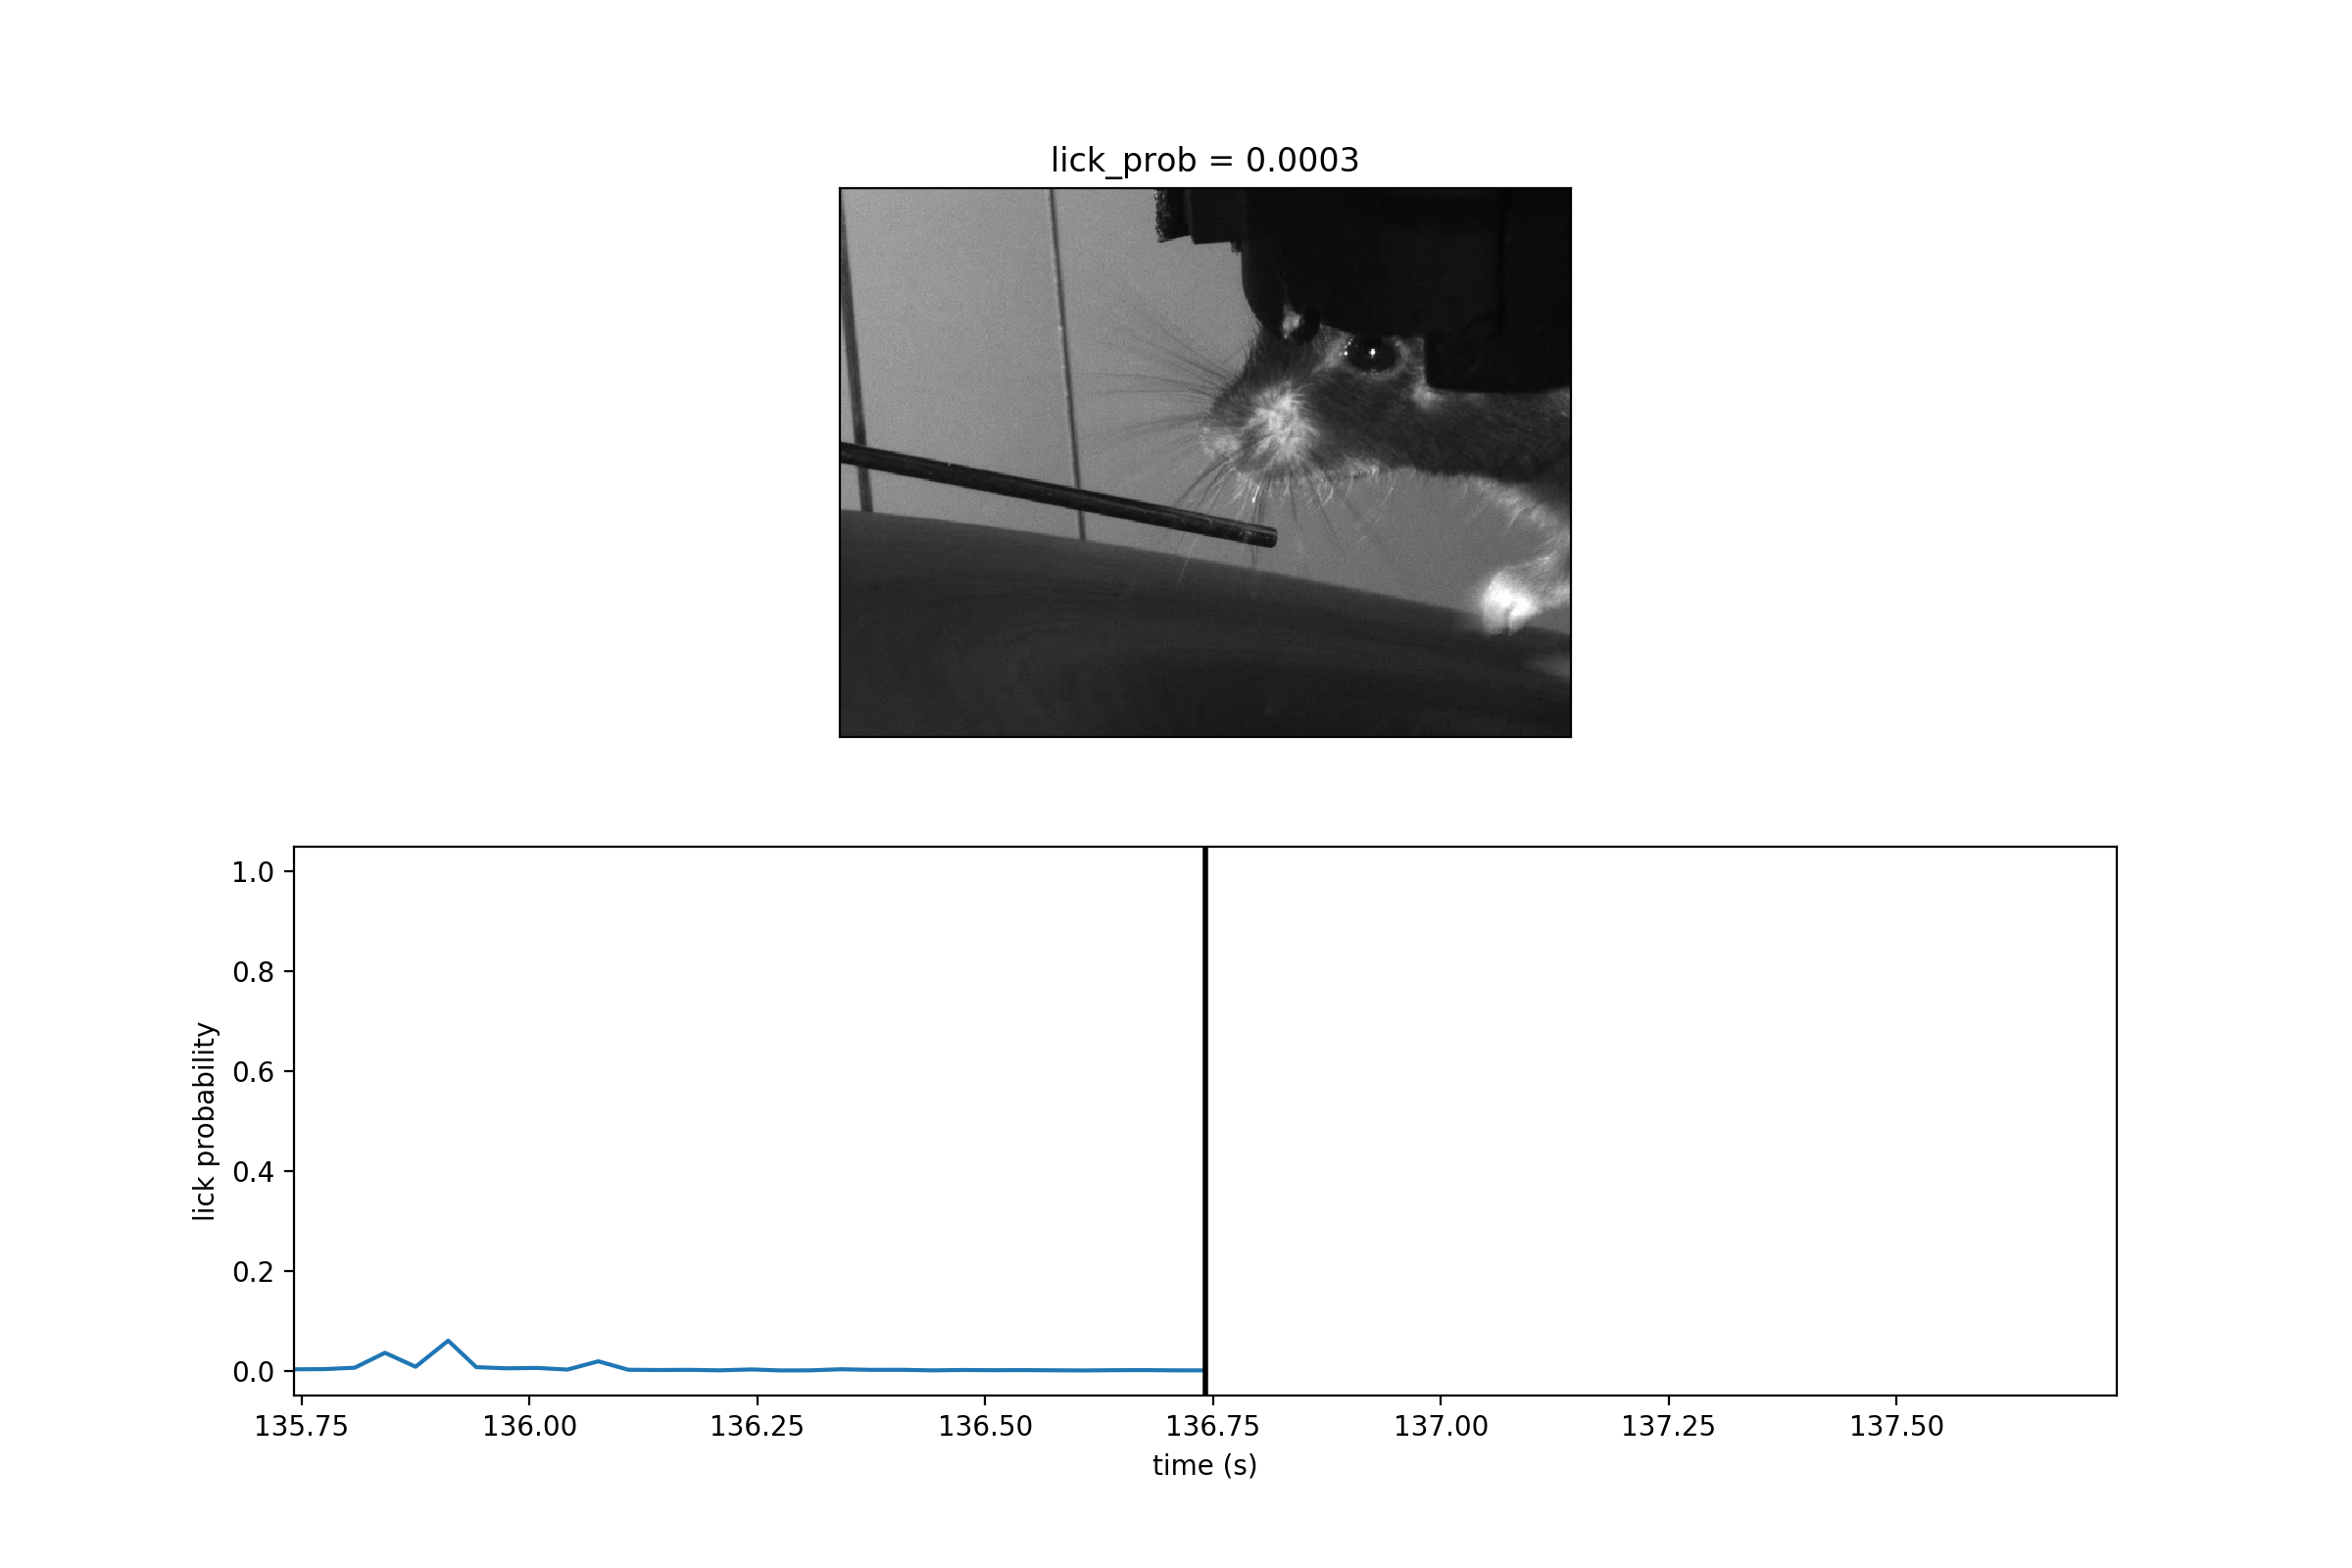

100%|██████████| 4096/4096 [30:57<00:00,  1.69it/s]


In [120]:
save_folder = '/ssd1/lick_detection_model/three_class_model/841948542_frames'
fig,ax=plt.subplots(2,1,figsize=(12,8))

for frame in tqdm(range(4096)):
    ax[0].cla()
    ax[1].cla()
    
    current_time = sync_data['cam1_exposure_rising'][frame]
    ax[0].imshow(movie.get_frame(frame))
    ax[0].set_title('lick_prob = {:0.4f}'.format(predictions['all_preds'][frame][2]))
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].plot(sync_data['cam1_exposure_rising'][:4096],predictions['all_preds'][:,2])
    ax[1].plot(licks.query('time <= @max_time'), np.ones_like(licks.query('time <= @max_time')), 'ok')
    ax[1].set_xlim(current_time-1,current_time+1)
    ax[1].axvline(current_time,color='black',linewidth=2)
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('lick probability')

    fig.savefig(os.path.join(save_folder,'frame={:0>5d}.png'.format(frame)),dpi=100)

<IPython.core.display.Javascript object>


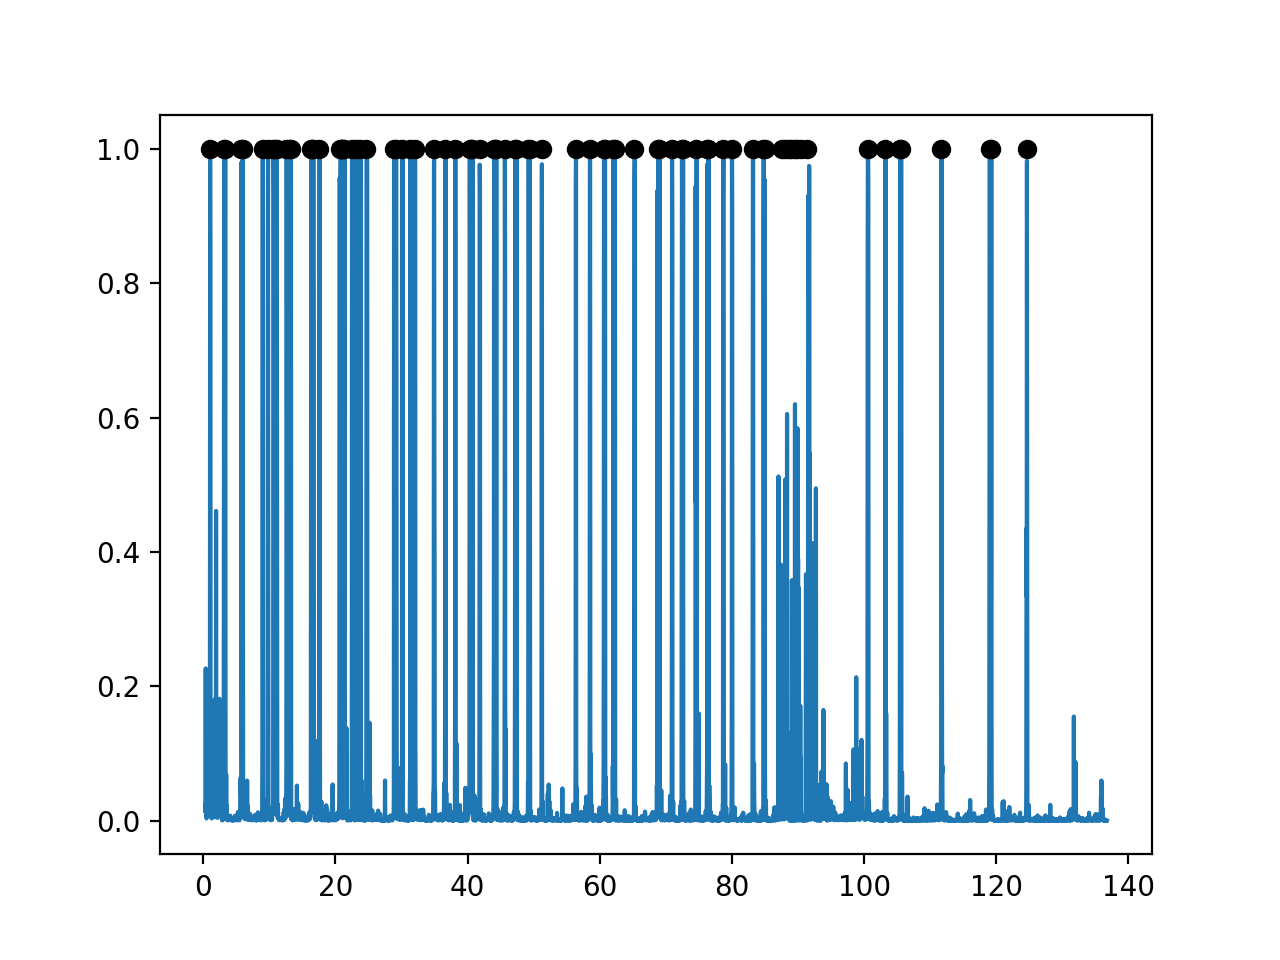

In [97]:
fig,ax=plt.subplots()
max_time = sync_data['cam1_exposure_rising'][4096]
ax.plot(sync_data['cam1_exposure_rising'][:4096],predictions['all_preds'][:,2])
ax.plot(licks.query('time <= @max_time'), np.ones_like(licks.query('time <= @max_time')), 'ok')

In [95]:
max_time = sync_data['cam1_exposure_rising'][4096]
licks.query('time <= @max_time')

,time
0,1.01708
1,3.14674
2,3.27260
3,5.77010
4,5.95047
5,8.97777
6,9.77713
7,10.59226
8,10.79162
9,11.10806
